In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from glob import glob

import numpy as np
from PIL import Image

In [ ]:
######NOT USED TRAINING PART########

'''
parser = argparse.ArgumentParser(description='PyTorch VAE')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 20)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='how many batches to wait before logging training status')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()



torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
'''
#kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = range(2080)
test_loader = range(40)

totensor = transforms.ToTensor()
def load_batch(batch_idx, istrain):
    if istrain:
        template = '../data/train/%s.jpg'
    else:
        template = '../data/test/%s.jpg'
    l = [str(batch_idx*128 + i).zfill(6) for i in range(128)]
    data = []
    for idx in l:
        img = Image.open(template%idx)
        data.append(np.array(img))
    data = [totensor(i) for i in data]
    return torch.stack(data, dim=0)

In [4]:
class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1, self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))

        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar


model = VAE(nc=3, ngf=128, ndf=128, latent_variable_size=500)

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx in train_loader:
        data = load_batch(batch_idx, True)
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), (len(train_loader)*128),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / (len(train_loader)*128)))
    return train_loss / (len(train_loader)*128)

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx in test_loader:
        data = load_batch(batch_idx, False)
        data = Variable(data, volatile=True)
        if args.cuda:
            data = data.cuda()
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

        torchvision.utils.save_image(data.data, '../imgs/Epoch_{}_data.jpg'.format(epoch), nrow=8, padding=2)
        torchvision.utils.save_image(recon_batch.data, '../imgs/Epoch_{}_recon.jpg'.format(epoch), nrow=8, padding=2)

    test_loss /= (len(test_loader)*128)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


def perform_latent_space_arithmatics(items): # input is list of tuples of 3 [(a1,b1,c1), (a2,b2,c2)]
    load_last_model()
    model.eval()
    data = [im for item in items for im in item]
    data = [totensor(i) for i in data]
    data = torch.stack(data, dim=0)
    data = Variable(data, volatile=True)
    if args.cuda:
        data = data.cuda()
    z = model.get_latent_var(data.view(-1, model.nc, model.ndf, model.ngf))
    it = iter(z.split(1))
    z = zip(it, it, it)
    zs = []
    numsample = 11
    for i,j,k in z:
        for factor in np.linspace(0,1,numsample):
            zs.append((i-j)*factor+k)
    z = torch.cat(zs, 0)
    recon = model.decode(z)

    it1 = iter(data.split(1))
    it2 = [iter(recon.split(1))]*numsample
    result = zip(it1, it1, it1, *it2)
    result = [im for item in result for im in item]

    result = torch.cat(result, 0)
    torchvision.utils.save_image(result.data, '../imgs/vec_math.jpg', nrow=3+numsample, padding=2)


def latent_space_transition(items): # input is list of tuples of  (a,b)
    load_last_model()
    model.eval()
    data = [im for item in items for im in item[:-1]]
    data = [totensor(i) for i in data]
    data = torch.stack(data, dim=0)
    data = Variable(data, volatile=True)
    if args.cuda:
        data = data.cuda()
    z = model.get_latent_var(data.view(-1, model.nc, model.ndf, model.ngf))
    it = iter(z.split(1))
    z = zip(it, it)
    zs = []
    numsample = 11
    for i,j in z:
        for factor in np.linspace(0,1,numsample):
            zs.append(i+(j-i)*factor)
    z = torch.cat(zs, 0)
    recon = model.decode(z)

    it1 = iter(data.split(1))
    it2 = [iter(recon.split(1))]*numsample
    result = zip(it1, it1, *it2)
    result = [im for item in result for im in item]

    result = torch.cat(result, 0)
    torchvision.utils.save_image(result.data, '../imgs/trans.jpg', nrow=2+numsample, padding=2)


def rand_faces(num=5):
    load_last_model()
    model.eval()
    z = torch.randn(num*num, model.latent_variable_size)
    z = Variable(z, volatile=True)
    recon = model.decode(z)
    torchvision.utils.save_image(recon.data, '../imgs/rand_faces.jpg', nrow=num, padding=2)

def load_last_model():
    models = glob('../models/*.pth')
    model_ids = [(int(f.split('_')[1]), f) for f in models]
    start_epoch, last_cp = max(model_ids, key=lambda item:item[0])
    print('Last checkpoint: ', last_cp)
    model.load_state_dict(torch.load(last_cp))
    return start_epoch, last_cp

def resume_training():
    start_epoch, _ = load_last_model()

    for epoch in range(start_epoch + 1, start_epoch + args.epochs + 1):
        train_loss = train(epoch)
        test_loss = test(epoch)
        torch.save(model.state_dict(), '../models/Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch, train_loss, test_loss))

def last_model_to_cpu():
    _, last_cp = load_last_model()
    model.cpu()
    torch.save(model.state_dict(), '../models/cpu_'+last_cp.split('/')[-1])

In [6]:
model.load_state_dict(torch.load('cpu_Epoch_28_Train_loss_25425.9503_Test_loss_25172.4120.pth'))

/Users/gexinyue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/gexinyue/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/Users/gexinyue/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


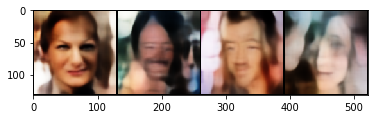

In [11]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


num = 2

z = torch.randn(3, model.latent_variable_size)
z = Variable(z, volatile=True)
recon = model.decode(z)
show(torchvision.utils.make_grid(recon.data, nrow=3, padding=2))





In [12]:
from ipywidgets import interact_manual, interact, Button
from IPython.display import display
import ipywidgets as widgets
#from hilbert import HilbertCurve
import numpy as np

global p_widget, v_widget, check_widget, hilbert_curve


from HilbertExplorer import HilbertExplorer

import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from glob import glob
def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()



N = model.latent_variable_size
#set t here
t = 0.3
p_initial = 10


hilbert_curve = HilbertExplorer(N,1)
hilbert_curve.setP(p_initial)  #require setting initial p value manually before using the curve
hilbert_curve.setT(t)



def plotting(p, v, c):
    print("current dist: " + str(hilbert_curve.dist))
    if p_widget.value != hilbert_curve.p:
        hilbert_curve.setP(p_widget.value)
    #print("AFTER" + str(hilbert_curve.dist))
    #print(hilbert_curve.getCoordFromDist(hilbert_curve.dist))
    
    coords = np.asarray([hilbert_curve.getNextCoordFromDist(-5,hilbert_curve.dist), hilbert_curve.getCoordFromDist(hilbert_curve.dist), hilbert_curve.getNextCoordFromDist(5,hilbert_curve.dist)])
    #b = torch.tensor(coords).type(torch.FloatTensor).to(device)
    
    z = torch.from_numpy(coords).float()
    z = Variable(z, volatile=True)
    recon = model.decode(z)
    show(torchvision.utils.make_grid(recon.data, nrow=3, padding=2))



    #sample = model.decode(b).cpu()
    #show(make_grid(sample.view(3, 1, 28, 28)))
    print(coords)
    #print(hilbert_curve.t)
    
    check_widget.value = 0
    


def on_button_clicked(b):
    

    hilbert_curve.updateDist(v_widget.value)
    
    #print(int(hilbert_curve.dist))
    #hilbert_curve.dist = int(hilbert_curve.dist)
    #print(hilbert_curve.dist)
    check_widget.value = 1
    #plotting(p_widget.value, v_widget.value)



p_widget = widgets.IntSlider(min = 1, max = 100, value = p_initial)
v_widget = widgets.IntSlider(min = 1, max = 100, value = 10)

check_widget = widgets.IntSlider(min = 0, max = 1, value = 0)
#check_widget.visible = False

button = Button (description = "Next Time Stamp")
display(button)
button.on_click(on_button_clicked)


interactive_plot = interact(plotting, p = p_widget, v=v_widget, c=check_widget)
interactive_plot



Button(description='Next Time Stamp', style=ButtonStyle())

interactive(children=(IntSlider(value=10, description='p', min=1), IntSlider(value=10, description='v', min=1)…

<function __main__.plotting(p, v, c)>